In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from amphibian import get_data_accessor
from r2d2 import query

<h1> MAU </h1>


In [110]:
mau_df = query ("""
with total_this_fy as (
select
    f.fiscal_month,
    f.fiscal_month_description_sortable,
    count(distinct vcpa.client_id) as mau
from curated_views.visitor_client_page_action as vcpa
left join curated.client on vcpa.client_id = client.client_id
left join curated_views.fiscal_date_plus as f on vcpa.date_in_utc = f.fiscal_date
where vcpa.canonical_page = 'homepage'
  and vcpa.date_in_utc >= date ('2021-11-01')
and vcpa.date_in_utc < date ('2022-04-01')
and client.business_line <> ''
group by 1,2

    ),

total_last_fy as (

select
    f.fiscal_month,
    f.fiscal_month_description_sortable,
    count(distinct vcpa.client_id) as mau
from curated_views.visitor_client_page_action as vcpa
left join curated.client on vcpa.client_id = client.client_id
left join curated_views.fiscal_date_plus as f on vcpa.date_in_utc = f.fiscal_date
where vcpa.canonical_page = 'homepage'
  and vcpa.date_in_utc >= date ('2020-11-01')
and vcpa.date_in_utc < date ('2021-04-01')
and client.business_line <> ''
group by 1,2

    )

select
    total_this_fy.*,
    round((total_this_fy.MAU-total_last_fy.MAU)/cast(total_last_fy.MAU as double),4) as prop_change_from_last_year
from total_this_fy
inner join total_last_fy on total_this_fy.fiscal_month =total_last_fy.fiscal_month
order by 2


""")
mau_df.rename(columns={"fiscal_month": "Month", "mau":"MAU", "prop_change_from_last_year":"% Change (From Last Year)"}, inplace = True)
mau_df['% Change (From Last Year)'] = mau_df['% Change (From Last Year)']*100

In [116]:
display(mau_df.drop(['fiscal_month_description_sortable'], axis = 1))

,Month,MAU,% Change (From Last Year)
0,Nov,1638118,61.24
1,Dec,1660154,77.14
2,Jan,1631784,63.00
3,Feb,1578609,77.39
4,Mar,1740730,50.25


In [108]:
mau_df['MAU'].mean()

1649879.0

Text(0.5, 1.0, 'Monthly Active Users')

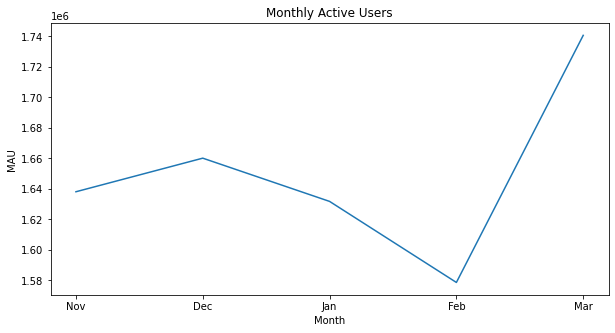

In [112]:
plt.figure(figsize=(10,5))
sns.lineplot(x= "Month", y="MAU", markers = True, data = mau_df)
plt.title("Monthly Active Users")

<h1>MAU by LOB</h1>

In [138]:
mau_lob = query("""

select
    f.fiscal_month,
    f.fiscal_month_description_sortable,
    client.business_line,
    count(distinct vcpa.client_id) as mau
from curated_views.visitor_client_page_action as vcpa
left join curated.client on vcpa.client_id = client.client_id
left join curated_views.fiscal_date_plus as f on vcpa.date_in_utc = f.fiscal_date
where vcpa.canonical_page = 'homepage'
  and vcpa.date_in_utc >= date ('2021-11-01')
and vcpa.date_in_utc < date ('2022-04-01')
and client.business_line <> ''
group by 1,2,3
order by 2
""")
mau_lob.rename(columns={"fiscal_month": "Month", "business_line":"LOB", "mau":"MAU", "fiscal_month_description_sortable":"Fiscal Month"}, inplace = True)

Text(0.5, 1.0, 'Monthly Active Users by LOB')

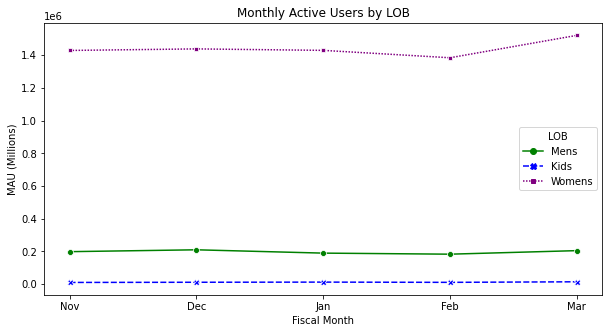

In [157]:
plt.figure(figsize=(10,5))
palette = ["green","blue","purple"]
line = sns.lineplot(x= "Month", y="MAU", hue = "LOB", style = "LOB", palette = palette, markers = True, data = mau_lob)\
    .set(xlabel = "Fiscal Month", ylabel = "MAU (Millions)")
plt.title("Monthly Active Users by LOB")


In [155]:
mau_lob_pivot = mau_lob.pivot(index=["LOB"], columns=["Fiscal Month"],values="MAU") \
       .sort_index()
mau_lob_pivot

Fiscal Month,2022 04 Nov,2022 05 Dec,2022 06 Jan,2022 07 Feb,2022 08 Mar
LOB,,,,,
Kids,10431,11575,12495,11019,14446
Mens,198655,210059,189739,183262,204950
Womens,1429032,1438520,1429550,1384328,1521334


<AxesSubplot:xlabel='Month', ylabel='Count'>

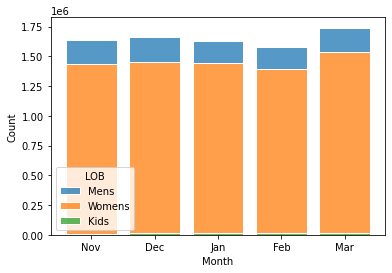

In [79]:
sns.histplot(
    mau_lob,
    x = 'Month',
    weights = 'MAU',
    hue = 'LOB',
    multiple = 'stack',
    edgecolor = 'white',
    shrink = 0.8
)

In [69]:
mau_lob.pivot(index=["Fiscal Month"], columns=["LOB"],values="MAU") \
       .sort_values("Fiscal Month") 

LOB,Kids,Mens,Womens
Fiscal Month,,,
2022 04 Nov,7909,193785,1395168
2022 05 Dec,8702,205717,1413205
2022 06 Jan,9166,185770,1406308
2022 07 Feb,8206,180031,1362992
2022 08 Mar,12189,203904,1515174


In [162]:
w_stick = query("""
with mau as (

select
    f.fiscal_month,
    f.fiscal_month_description_sortable,
    count(distinct vcpa.client_id) as mau
from curated_views.visitor_client_page_action as vcpa
left join curated.client on vcpa.client_id = client.client_id
left join curated_views.fiscal_date_plus as f on vcpa.date_in_utc = f.fiscal_date
where vcpa.canonical_page = 'homepage'
  and vcpa.date_in_utc >= date ('2021-11-01')
and vcpa.date_in_utc < date ('2022-04-01')
and client.business_line <> ''
group by 1,2

),

wau_base as (

select
    f.fiscal_month,
    date_trunc('week',vcpa.date_in_utc) as week,
    f.fiscal_month_description_sortable,
    count(distinct vcpa.client_id) as wau
from curated_views.visitor_client_page_action as vcpa
left join curated.client on vcpa.client_id = client.client_id
left join curated_views.fiscal_date_plus as f on vcpa.date_in_utc = f.fiscal_date
where vcpa.canonical_page = 'homepage'
  and vcpa.date_in_utc >= date ('2021-11-01')
and vcpa.date_in_utc < date ('2022-04-01')
and client.business_line <> ''
group by 1,2,3
order by 2

),

avg_wau as (

select
    fiscal_month,
    round(avg(wau)) as avg_wau
from wau_base
group by 1

)

select
    mau.*,
    avg_wau.avg_wau,
    round(avg_wau.avg_wau/cast(mau.mau as double),4) as stickiness_prop
from mau
left join avg_wau on mau.fiscal_month = avg_wau.fiscal_month
order by 2
""")

In [167]:
w_stick['stickiness_perc'] = w_stick['stickiness_prop']*100
display(w_stick)

,fiscal_month,fiscal_month_description_sortable,mau,avg_wau,stickiness_prop,stickiness_perc
0,Nov,2022 04 Nov,1638118,804471.0,0.4911,49.11
1,Dec,2022 05 Dec,1660154,629436.0,0.3791,37.91
2,Jan,2022 06 Jan,1631784,658930.0,0.4038,40.38
3,Feb,2022 07 Feb,1578609,634490.0,0.4019,40.19
4,Mar,2022 08 Mar,1740730,645940.0,0.3711,37.11


Text(0.5, 1.0, 'Weekly Stickiness by Month')

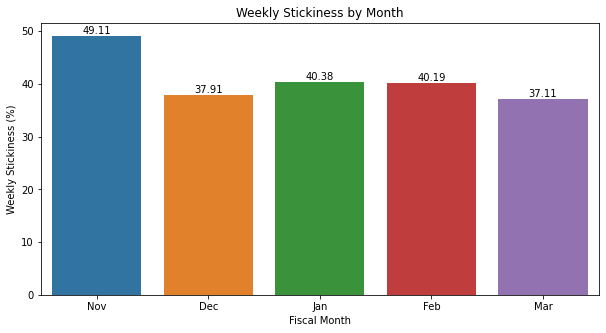

In [171]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='fiscal_month', y='stickiness_perc', data=w_stick)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Fiscal Month', ylabel='Weekly Stickiness (%)')
plt.title("Weekly Stickiness by Month")

In [172]:
d_stick = query("""
with mau as (

select
    f.fiscal_month,
    f.fiscal_month_description_sortable,
    count(distinct vcpa.client_id) as mau
from curated_views.visitor_client_page_action as vcpa
left join curated.client on vcpa.client_id = client.client_id
left join curated_views.fiscal_date_plus as f on vcpa.date_in_utc = f.fiscal_date
where vcpa.canonical_page = 'homepage'
  and vcpa.date_in_utc >= date ('2021-11-01')
and vcpa.date_in_utc < date ('2022-04-01')
and client.business_line <> ''
group by 1,2

),

dau_base as (

select
    f.fiscal_month,
    vcpa.date_in_utc as date,
    f.fiscal_month_description_sortable,
    count(distinct vcpa.client_id) as dau
from curated_views.visitor_client_page_action as vcpa
left join curated.client on vcpa.client_id = client.client_id
left join curated_views.fiscal_date_plus as f on vcpa.date_in_utc = f.fiscal_date
where vcpa.canonical_page = 'homepage'
  and vcpa.date_in_utc >= date ('2021-11-01')
and vcpa.date_in_utc < date ('2022-04-01')
and client.business_line <> ''
group by 1,2,3
order by 2

),

avg_dau as (

select
    fiscal_month,
    round(avg(dau)) as avg_dau
from dau_base
group by 1

)

select
    mau.*,
    avg_dau.avg_dau,
    round(round(avg_dau.avg_dau/cast(mau.mau as double),4)*100,2) as stickiness_perc
from mau
left join avg_dau on mau.fiscal_month = avg_dau.fiscal_month
order by 2
""")

Text(0.5, 1.0, 'Daily Stickiness by Month')

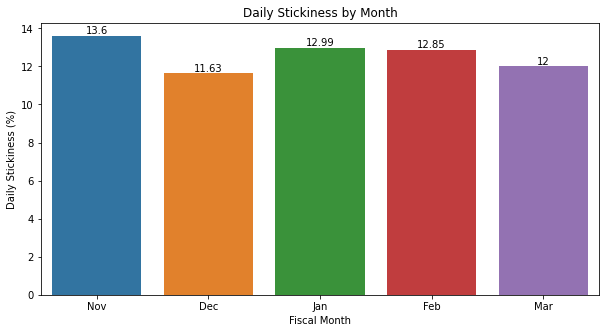

In [174]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='fiscal_month', y='stickiness_perc', data=d_stick)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Fiscal Month', ylabel='Daily Stickiness (%)')
plt.title("Daily Stickiness by Month")

<h1> Percent of Sessions w/Homefeed Visit </h1>


In [3]:
hf_visit = query("""
with hf as (

select
    f.fiscal_month_description_sortable,
    count(distinct ptl.algo_session_id) as homefeed_sessions
from curated.product_tracking_logs as ptl
inner join curated.client on ptl.client_id = client.client_id and client.employee_affiliated_flag = 0
inner join curated.buyable on ptl.client_id = buyable.client_id and buyable_type = 'shipment'
inner join curated_views.fiscal_date_plus as f on ptl.date_in_utc = f.fiscal_date and f.fiscal_year >= 2022
where ptl.canonical_name = 'homepage'
group by 1
),

tot as (
-- total sessions
select
    f.fiscal_month_description_sortable,
    count(distinct ptl.algo_session_id) as total_sessions
from curated.product_tracking_logs as ptl
inner join curated.client on ptl.client_id = client.client_id and client.employee_affiliated_flag = 0
inner join curated.buyable on ptl.client_id = buyable.client_id and buyable_type = 'shipment'
inner join curated_views.fiscal_date_plus as f on ptl.date_in_utc = f.fiscal_date and f.fiscal_year >= 2022
group by 1
)

select
    hf.fiscal_month_description_sortable,
    hf.homefeed_sessions,
    tot.total_sessions,
    round(hf.homefeed_sessions/cast(tot.total_sessions as double),4) as percent_of_sessions_w_hf_visit
from hf
left join tot on hf.fiscal_month_description_sortable = tot.fiscal_month_description_sortable
order by 1

""")


[Text(0, 0, '2022 01 Aug'),
 Text(1, 0, '2022 02 Sep'),
 Text(2, 0, '2022 03 Oct'),
 Text(3, 0, '2022 04 Nov'),
 Text(4, 0, '2022 05 Dec'),
 Text(5, 0, '2022 06 Jan'),
 Text(6, 0, '2022 07 Feb'),
 Text(7, 0, '2022 08 Mar'),
 Text(8, 0, '2022 09 Apr'),
 Text(9, 0, '2022 10 May')]

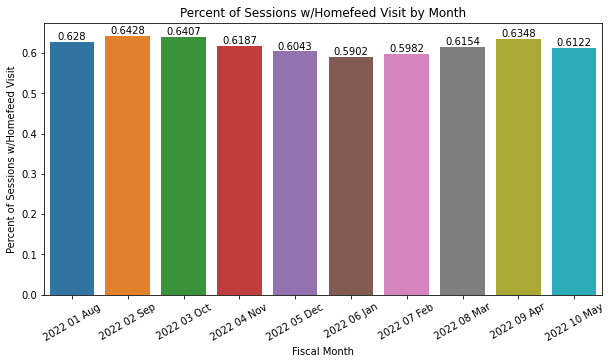

In [6]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='fiscal_month_description_sortable', y='percent_of_sessions_w_hf_visit', data=hf_visit)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Fiscal Month', ylabel='Percent of Sessions w/Homefeed Visit')
plt.title("Percent of Sessions w/Homefeed Visit by Month")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

<h1> 40.6% </h1>

<h1> 30 Day Homefeed Revisit Rate </h1>

In [5]:
rvr_30 = query("""
select
    round(count(distinct t2.client_id)/cast(count(distinct t1.client_id) as double),4) as hf_revisit_rate
from curated.product_tracking_logs as t1
inner join curated.client on t1.client_id = client.client_id and client.style_profile_completed_ts is not null and client.employee_affiliated_flag = 0
left join curated.product_tracking_logs as t2 on t1.client_id = t2.client_id and t1.date_in_utc < t2.date_in_utc and date_diff('day',t1.date_in_utc, t2.date_in_utc) <= 30
and t2.canonical_name = 'homepage'
and t2.action_type = 'view'
and t2.date_in_utc <= date_add('day',-31,current_date)
and t2.date_in_utc >= date_add('day',-61,current_date )
where t1.canonical_name = 'homepage'
and t1.action_type = 'view'
and t1.date_in_utc <= date_add('day',-31,current_date)
and t1.date_in_utc >= date_add('day',-61,current_date)


""")
rvr_30

,hf_revisit_rate
0,0.6083


<h1> Scroll Distance </h1>

In [7]:
scroll_dist = query("""

with base as (

select
    mi.recommendation_id,
    cast(json_extract(mi.parent_module_entry[1], '$.feedSequenceNumber') as int) as position_in_feed,
    mi.action_type
from apoc.module_interactions as mi
inner join curated.client on cast(mi.client_id as int) = client.client_id and client.employee_affiliated_flag = 0
left join apoc.page_views as pv on mi.recommendation_id = pv.recommendation_id
and mi.dateint = pv.dateint
left join curated.dim_user_agent as d on pv.user_agent = d.user_agent
where cast(date_parse(mi.dateint,'%Y%m%d') as date) >= date_add('day',-31,current_date)
and mi.action_type in ('scroll')
and mi.module is not null
and mi.module <> 'communityInspirationModuleV2'

union all

select
    mi.recommendation_id,
    cast(json_extract(mi.parent_module_entry[1], '$.feedSequenceNumber') as int) as position_in_feed,
    mi.action_type
from apoc.module_interactions as mi
inner join curated.client on cast(mi.client_id as int) = client.client_id and client.employee_affiliated_flag = 0
left join apoc.page_views as pv on mi.recommendation_id = pv.recommendation_id
and mi.dateint = pv.dateint
left join curated.dim_user_agent as d on pv.user_agent = d.user_agent
where cast(date_parse(mi.dateint,'%Y%m%d') as date) >= date_add('day',-31,current_date)
and mi.action_type in ('scroll')
and mi.module is not null
and mi.module = 'communityInspirationModuleV2'
and d.derived_platform_name <> 'iOS'

),

tot as (

select
    count(distinct recommendation_id) as total
from base

),

agg as (

select
    recommendation_id,
    max(position_in_feed) as modules_loaded
from base
where action_type = 'scroll'
group by 1

),

scrolls as (

select
    modules_loaded,
    count(*) as num_instances
from agg
group by 1

)

select
    scrolls.*,
    round(scrolls.num_instances/cast(tot.total as double),4) as percent_of_total
from scrolls
cross join tot

""")
scroll_dist['percent_of_total'] = scroll_dist['percent_of_total']*100

In [10]:
scroll_dist['modules_loaded'] = scroll_dist['modules_loaded'].fillna(0.0).astype(int)
scroll_dist.sort_values(by = ['modules_loaded'], ascending = False, inplace = True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '26')])

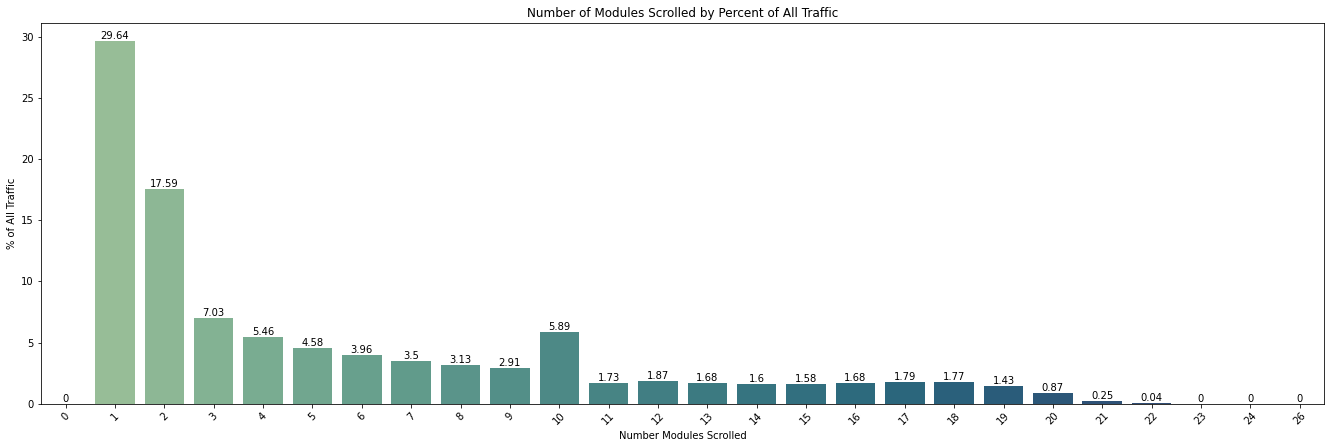

In [12]:
plt.figure(figsize=(23,7))
ax = sns.barplot(x='modules_loaded', y='percent_of_total', data=scroll_dist, palette = 'crest')
ax.bar_label(ax.containers[0])
ax.set(xlabel='Number Modules Scrolled', ylabel='% of All Traffic')
plt.title("Number of Modules Scrolled by Percent of All Traffic")
plt.xticks(rotation = 45)

<h1> Homefeed Scroll, Bounce, and Interaction Rate Last 30 Days </h1>

In [7]:
scroll = query("""

with vsp as (

select
    algo_session_id,
    canonical_name,
    step_ahead_1,
    datetime_in_utc as entered_page,
    lead(datetime_in_utc) over (partition by algo_session_id order by datetime_in_utc) as next_page_visited_at
from curated.visitor_client_path
inner join curated.client on visitor_client_path.client_id = client.client_id and client.style_profile_completed_ts is not null and client.employee_affiliated_flag = 0
where date_in_utc >= date_add('day',-31,current_date)

),

scroll_base as (

select
    vsp.algo_session_id,
    vsp.entered_page,
    vsp.next_page_visited_at,
    case when count(distinct find_scroll.datetime_in_utc) > 2 then 1 else 0 end as did_scroll,
    case when count(distinct find_click.datetime_in_utc) > 0 then 1 else 0 end as did_click
from vsp
left join curated.product_tracking_logs_event_context as find_scroll on vsp.algo_session_id = find_scroll.algo_session_id
and find_scroll.action_detail = 'homepage_with_feed_v2'
and find_scroll.action_type = 'scroll'
and find_scroll.date_in_utc >= date_add('day',-31,current_date)
and (vsp.entered_page < find_scroll.datetime_in_utc and find_scroll.datetime_in_utc < vsp.next_page_visited_at or vsp.next_page_visited_at is null)
left join curated.product_tracking_logs_event_context as find_click on vsp.algo_session_id = find_click.algo_session_id
and find_click.action_detail = 'homepage_with_feed_v2'
and find_click.action_type = 'click'
and find_click.date_in_utc >= date_add('day',-31,current_date)
and (vsp.entered_page < find_click.datetime_in_utc and find_click.datetime_in_utc < vsp.next_page_visited_at or vsp.next_page_visited_at is null)
where vsp.canonical_name = 'homepage'
group by 1,2,3

)

select
    count(*),
    sum(case when next_page_visited_at is null then 1 else 0 end) as bounced,
    sum(case when next_page_visited_at is null and did_scroll = 0 then 1 else 0 end) as bounced_w_no_scroll,
    sum(did_scroll) as scrolled,
    round(sum(did_scroll)/cast(count(*) as double),4) as scroll_rate,
    round(sum(case when next_page_visited_at is null then 1 else 0 end)/cast(count(*) as double),4) as bounce_rate,
    round(sum(case when next_page_visited_at is null and did_scroll = 0 then 1 else 0 end)/cast(count(*) as double),4) as bounce_no_scroll_rate,
    round(sum(did_click)/cast(count(*) as double),4) as interaction_rate
from scroll_base






""")
scroll

,_col0,bounced,bounced_w_no_scroll,scrolled,scroll_rate,bounce_rate,bounce_no_scroll_rate,interaction_rate
0,11623856,3694062,990763,6963320,0.5991,0.3178,0.0852,0.3447


<h1> Homefeed Subsequent Page Traffic </h1>

In [47]:
spt = query("""
with cte as (

select
    step_ahead_1,
    count(*) as num_instances
from curated.visitor_client_path
inner join curated.client on visitor_client_path.client_id = client.client_id and client.style_profile_completed_ts is not null and client.employee_affiliated_flag = 0
where date_in_utc >= date_add('day',-31,current_date)
and canonical_name = 'homepage'
group by 1

),

base as (

select
    step_ahead_1,
    num_instances,
    round(num_instances/(select cast(sum(num_instances) as double) from cte),4) as traffic_prop
from cte

)

select
    case when traffic_prop < .01 then 'other' else step_ahead_1 end as step_ahead,
    round(sum(num_instances)/(select cast(sum(num_instances) as double) from cte),4) as traffic_prop
from base
group by 1

""")

In [48]:
spt['traffic_prop'] = spt['traffic_prop']*100
spt.sort_values(by = ['traffic_prop'], ascending = False, inplace = True)
spt['step_ahead'] = np.where(spt['step_ahead'].isnull(), "None - Bounced", spt['step_ahead'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'None - Bounced'),
  Text(1, 0, 'pdp'),
  Text(2, 0, 'logged_in_visit'),
  Text(3, 0, 'complete_my_looks_home_page'),
  Text(4, 0, 'categories'),
  Text(5, 0, 'order_index'),
  Text(6, 0, 'other'),
  Text(7, 0, 'shop_index'),
  Text(8, 0, 'logged_in_landing'),
  Text(9, 0, 'shopping_bag'),
  Text(10, 0, 'fix_preview_items'),
  Text(11, 0, 'saved_items'),
  Text(12, 0, 'categories_landing')])

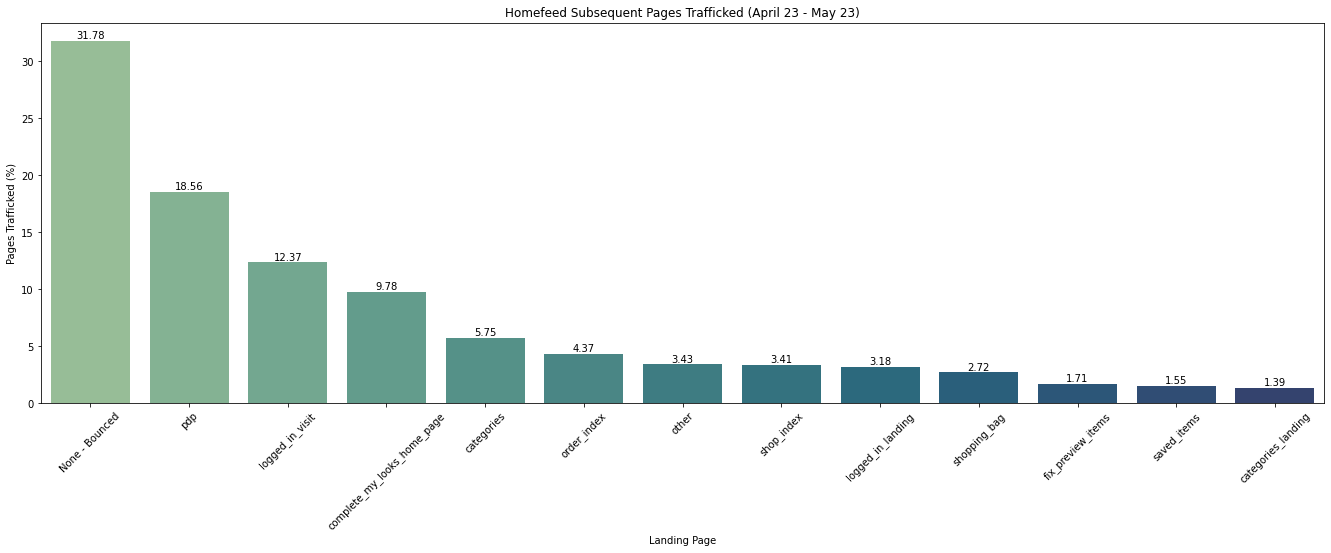

In [49]:
plt.figure(figsize=(23,7))
ax = sns.barplot(x='step_ahead', y='traffic_prop', data=spt, palette = 'crest')
ax.bar_label(ax.containers[0])
ax.set(xlabel='Landing Page', ylabel='Pages Trafficked (%)')
plt.title("Homefeed Subsequent Pages Trafficked (April 23 - May 23)")
plt.xticks(rotation = 45)

<h1> End of Feed % </h1>

In [31]:
eof = query("""

select
    count(distinct pv.recommendation_id) as page_views,
    sum(case when mi.client_id is not null then 1 else 0 end) as reached_eof,
    round(sum(case when mi.client_id is not null then 1 else 0 end)/cast(count(distinct pv.recommendation_id) as double),4) as eof_prop
from apoc.page_views as pv
inner join curated.client on cast(pv.client_id as int) = client.client_id and client.employee_affiliated_flag = 0
left join apoc.module_interactions as mi on pv.recommendation_id = mi.recommendation_id
and mi.module = 'endOfFeedModule'
and cast(date_parse(mi.dateint,'%Y%m%d') as date) >= date_add('day',-31,current_date)
where cast(date_parse(pv.dateint,'%Y%m%d') as date) >= date_add('day',-31,current_date)


""")
eof

,page_views,reached_eof,eof_prop
0,9035443,692532,0.0766


<h1> Module Interaction </h1>

In [16]:
# excludes communityInspirationModuleV2 module on iOS
mi = query("""
select
    mi.module,
    sum(case when mi.action_type = 'scroll' then 1 else 0 end) as module_viewed,
    sum(case when mi.action_type = 'click' then 1 else 0 end) as module_clicked,
    round(sum(case when mi.action_type = 'click' then 1 else 0 end)/cast(sum(case when mi.action_type = 'scroll' then 1 else 0 end)  as double),4) as ctr
--     (select count(*) from apoc.page_views where recommendation_id is not null and cast(date_parse(dateint,'%Y%m%d') as date) >= date_add('day',-30,current_date)) as total_homefeed_views
from apoc.module_interactions as mi
inner join curated.client on cast(mi.client_id as int) = client.client_id and client.employee_affiliated_flag = 0
left join apoc.page_views as pv on mi.recommendation_id = pv.recommendation_id
and mi.dateint = pv.dateint
left join curated.dim_user_agent as d on pv.user_agent = d.user_agent
where cast(date_parse(mi.dateint,'%Y%m%d') as date) >= date_add('day',-31,current_date)
and mi.action_type in ('scroll','click')
and mi.module is not null
and mi.module <> 'communityInspirationModuleV2'
group by 1
having sum(case when mi.action_type = 'click' then 1 else 0 end) > 0

union

select
    mi.module,
    sum(case when mi.action_type = 'scroll' then 1 else 0 end) as module_viewed,
    sum(case when mi.action_type = 'click' then 1 else 0 end) as module_clicked,
    round(sum(case when mi.action_type = 'click' then 1 else 0 end)/cast(sum(case when mi.action_type = 'scroll' then 1 else 0 end)  as double),4) as ctr
--     (select count(*) from apoc.page_views where recommendation_id is not null and cast(date_parse(dateint,'%Y%m%d') as date) >= date_add('day',-30,current_date)) as total_homefeed_views
from apoc.module_interactions as mi
inner join curated.client on cast(mi.client_id as int) = client.client_id and client.employee_affiliated_flag = 0
left join apoc.page_views as pv on mi.recommendation_id = pv.recommendation_id
and mi.dateint = pv.dateint
left join curated.dim_user_agent as d on pv.user_agent = d.user_agent
where cast(date_parse(mi.dateint,'%Y%m%d') as date) >= date_add('day',-31,current_date)
and mi.action_type in ('scroll','click')
and mi.module is not null
and mi.module = 'communityInspirationModuleV2'
and d.derived_platform_name <> 'iOS'
group by 1
order by 4 desc


""")
mi['ctr'] = mi['ctr']*100

In [17]:
display(mi)

,module,module_viewed,module_clicked,ctr
0,splitPanelPromoModule,44129,5979,13.55
1,endCardModule,309695,40278,13.01
2,gridPromoModule,3068031,379677,12.38
3,stylistBlogModule,1393467,151071,10.84
4,shoppableOutfitModule,3037709,328124,10.80
5,shoppableProductModule,26216150,2035975,7.77
6,carouselModule,39211691,3004683,7.66
7,communityInspirationModuleV2,2135480,160806,7.53
8,stackModule,13347177,997104,7.47
9,feedModule,80634402,5115621,6.34


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'splitPanelPromoModule'),
  Text(1, 0, 'endCardModule'),
  Text(2, 0, 'gridPromoModule'),
  Text(3, 0, 'stylistBlogModule'),
  Text(4, 0, 'shoppableOutfitModule'),
  Text(5, 0, 'shoppableProductModule'),
  Text(6, 0, 'carouselModule'),
  Text(7, 0, 'communityInspirationModuleV2'),
  Text(8, 0, 'stackModule'),
  Text(9, 0, 'feedModule'),
  Text(10, 0, 'quizModule'),
  Text(11, 0, 'engHydratedModule'),
  Text(12, 0, 'promoModuleV2'),
  Text(13, 0, 'gridModule')])

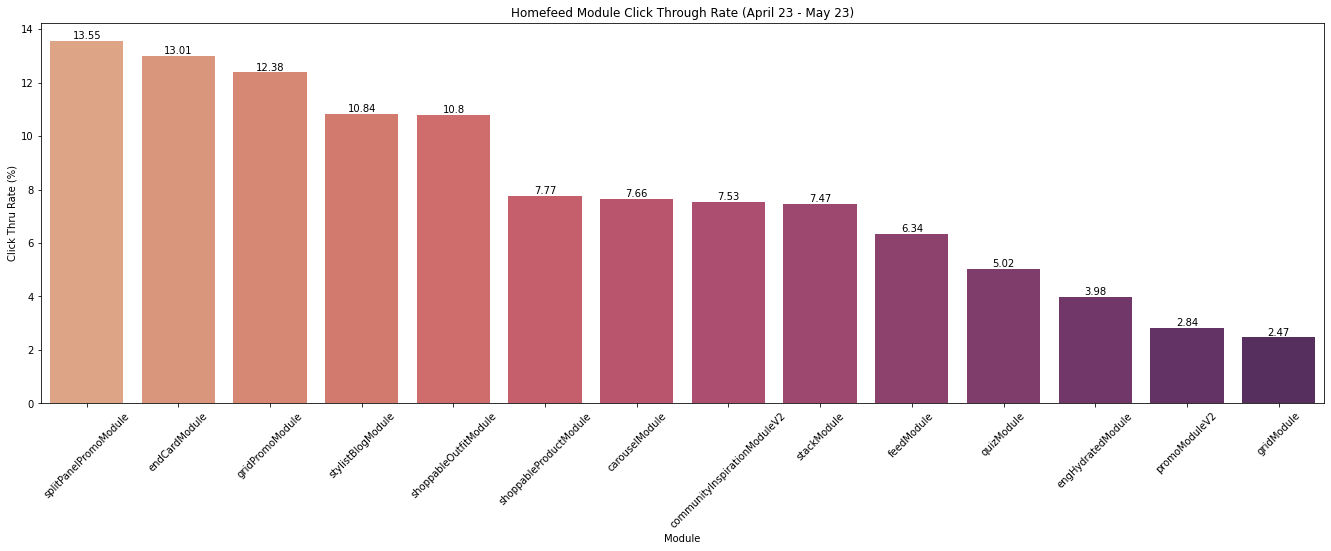

In [18]:
plt.figure(figsize=(23,7))
ax = sns.barplot(x='module', y='ctr', data=mi, palette = 'flare')
ax.bar_label(ax.containers[0])
ax.set(xlabel='Module', ylabel='Click Thru Rate (%)')
plt.title("Homefeed Module Click Through Rate (April 23 - May 23)")
plt.xticks(rotation = 45)

In [14]:
# Position in Feed, excludes iOS Community inspiration module v2
pif = query("""
with base as (

select
    cast(json_extract(mi.parent_module_entry[1], '$.feedSequenceNumber') as int) as position_in_feed,
    mi.action_type
from apoc.module_interactions as mi
inner join curated.client on cast(mi.client_id as int) = client.client_id and client.employee_affiliated_flag = 0
left join apoc.page_views as pv on mi.recommendation_id = pv.recommendation_id
and mi.dateint = pv.dateint
left join curated.dim_user_agent as d on pv.user_agent = d.user_agent
where cast(date_parse(mi.dateint,'%Y%m%d') as date) >= date_add('day',-31,current_date)
and mi.action_type in ('scroll','click')
and mi.module is not null
and mi.module <> 'communityInspirationModuleV2'

union all

select
    cast(json_extract(mi.parent_module_entry[1], '$.feedSequenceNumber') as int) as position_in_feed,
    mi.action_type
from apoc.module_interactions as mi
inner join curated.client on cast(mi.client_id as int) = client.client_id and client.employee_affiliated_flag = 0
left join apoc.page_views as pv on mi.recommendation_id = pv.recommendation_id
and mi.dateint = pv.dateint
left join curated.dim_user_agent as d on pv.user_agent = d.user_agent
where cast(date_parse(mi.dateint,'%Y%m%d') as date) >= date_add('day',-31,current_date)
and mi.action_type in ('scroll','click')
and mi.module is not null
and mi.module = 'communityInspirationModuleV2'
and d.derived_platform_name <> 'iOS'

)

select
    position_in_feed,
    sum(case when action_type = 'scroll' then 1 else 0 end) as module_viewed,
    sum(case when action_type = 'click' then 1 else 0 end) as module_clicked,
    round(sum(case when action_type = 'click' then 1 else 0 end)/cast(sum(case when action_type = 'scroll' then 1 else 0 end)  as double),4) as ctr
from base
group by 1
having sum(case when action_type = 'click' then 1 else 0 end) > 0 



""")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, '1.0'),
  Text(1, 0, '2.0'),
  Text(2, 0, '3.0'),
  Text(3, 0, '4.0'),
  Text(4, 0, '5.0'),
  Text(5, 0, '6.0'),
  Text(6, 0, '7.0'),
  Text(7, 0, '8.0'),
  Text(8, 0, '9.0'),
  Text(9, 0, '10.0'),
  Text(10, 0, '11.0'),
  Text(11, 0, '12.0'),
  Text(12, 0, '13.0'),
  Text(13, 0, '14.0'),
  Text(14, 0, '15.0'),
  Text(15, 0, '16.0'),
  Text(16, 0, '17.0'),
  Text(17, 0, '18.0'),
  Text(18, 0, '19.0'),
  Text(19, 0, '20.0'),
  Text(20, 0, '21.0'),
  Text(21, 0, '22.0'),
  Text(22, 0, '24.0')])

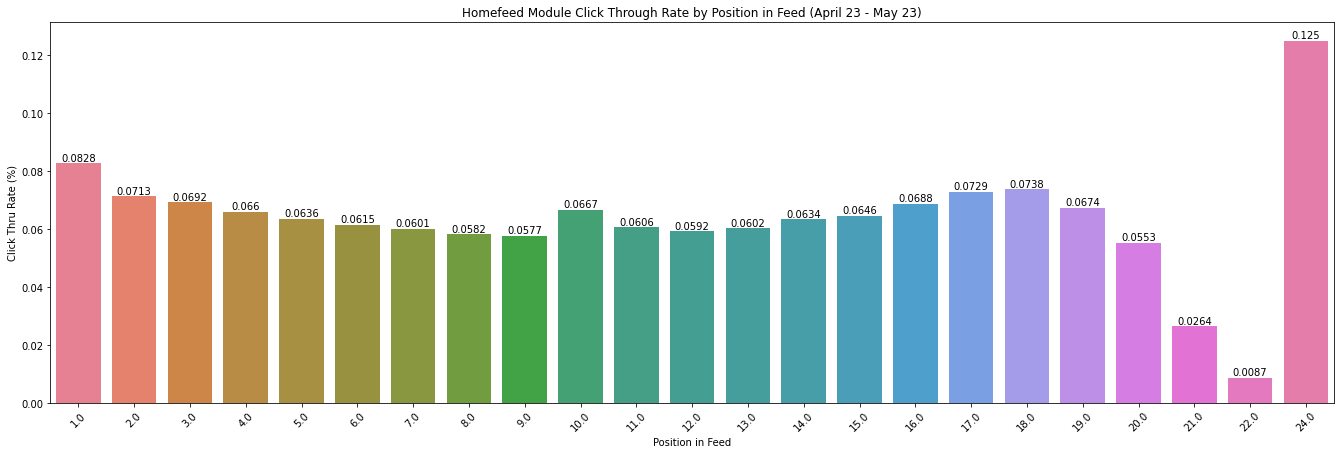

In [15]:
plt.figure(figsize=(23,7))
ax = sns.barplot(x='position_in_feed', y='ctr', data=pif, palette = 'husl')
ax.bar_label(ax.containers[0])
ax.set(xlabel='Position in Feed', ylabel='Click Thru Rate (%)')
plt.title("Homefeed Module Click Through Rate by Position in Feed (April 23 - May 23)")
plt.xticks(rotation = 45)

In [34]:
# Module and Position in Feed
mpif = query("""
with base as (

select
    mi.module,
    cast(json_extract(mi.parent_module_entry[1], '$.feedSequenceNumber') as int) as position_in_feed,
    mi.action_type
from apoc.module_interactions as mi
inner join curated.client on cast(mi.client_id as int) = client.client_id and client.employee_affiliated_flag = 0
left join apoc.page_views as pv on mi.recommendation_id = pv.recommendation_id
and mi.dateint = pv.dateint
left join curated.dim_user_agent as d on pv.user_agent = d.user_agent
where cast(date_parse(mi.dateint,'%Y%m%d') as date) >= date_add('day',-31,current_date)
and mi.action_type in ('scroll','click')
and mi.module is not null
and mi.module <> 'communityInspirationModuleV2'
and cast(json_extract(mi.parent_module_entry[1], '$.feedSequenceNumber') as int) is not null

union all

select
    mi.module,
    cast(json_extract(mi.parent_module_entry[1], '$.feedSequenceNumber') as int) as position_in_feed,
    mi.action_type
from apoc.module_interactions as mi
inner join curated.client on cast(mi.client_id as int) = client.client_id and client.employee_affiliated_flag = 0
left join apoc.page_views as pv on mi.recommendation_id = pv.recommendation_id
and mi.dateint = pv.dateint
left join curated.dim_user_agent as d on pv.user_agent = d.user_agent
where cast(date_parse(mi.dateint,'%Y%m%d') as date) >= date_add('day',-31,current_date)
and mi.action_type in ('scroll','click')
and mi.module is not null
and mi.module = 'communityInspirationModuleV2'
and d.derived_platform_name <> 'iOS'
and cast(json_extract(mi.parent_module_entry[1], '$.feedSequenceNumber') as int) is not null

)

select
    module,
    position_in_feed,
    sum(case when action_type = 'scroll' then 1 else 0 end) as module_viewed,
    sum(case when action_type = 'click' then 1 else 0 end) as module_clicked,
    round(sum(case when action_type = 'click' then 1 else 0 end)/cast(sum(case when action_type = 'scroll' then 1 else 0 end)  as double),4) as ctr
from base
group by 1,2
having sum(case when action_type = 'click' then 1 else 0 end) > 0


""")


In [35]:
display(mpif)

,module,position_in_feed,module_viewed,module_clicked,ctr
0,communityInspirationModuleV2,9,92401,7290,0.0789
1,communityInspirationModuleV2,3,236392,17425,0.0737
2,communityInspirationModuleV2,11,64961,5383,0.0829
3,gridPromoModule,5,250110,28404,0.1136
4,gridModule,21,360,15,0.0417
...,...,...,...,...,...
270,engHydratedModule,3,346562,12850,0.0371
271,engHydratedModule,4,295658,10775,0.0364
272,stackModule,11,346356,23344,0.0674
273,gridModule,11,162799,3273,0.0201


In [41]:
mpif_1 = mpif[mpif['position_in_feed'] == 1].sort_values(['ctr'], ascending = False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'splitPanelPromoModule'),
  Text(1, 0, 'endCardModule'),
  Text(2, 0, 'gridPromoModule'),
  Text(3, 0, 'stylistBlogModule'),
  Text(4, 0, 'shoppableOutfitModule'),
  Text(5, 0, 'stackModule'),
  Text(6, 0, 'carouselModule'),
  Text(7, 0, 'shoppableProductModule'),
  Text(8, 0, 'communityInspirationModuleV2'),
  Text(9, 0, 'quizModule'),
  Text(10, 0, 'promoModuleV2'),
  Text(11, 0, 'engHydratedModule'),
  Text(12, 0, 'gridModule')])

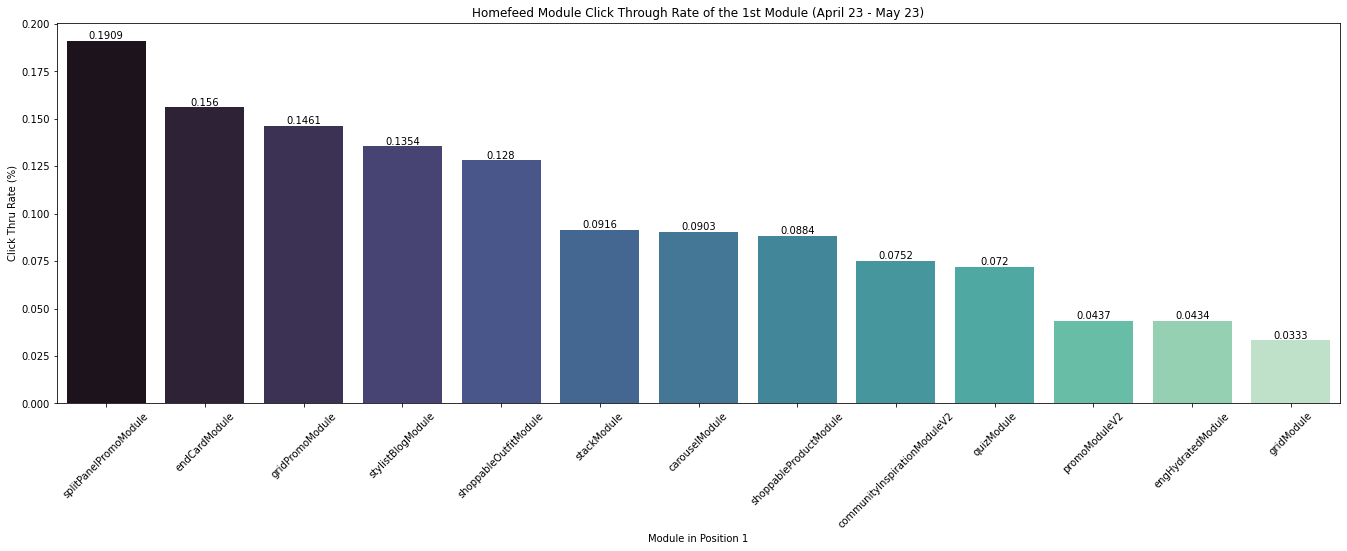

In [42]:
plt.figure(figsize=(23,7))
ax = sns.barplot(x='module', y='ctr', data=mpif_1, palette = 'mako')
ax.bar_label(ax.containers[0])
ax.set(xlabel='Module in Position 1', ylabel='Click Thru Rate (%)')
plt.title("Homefeed Module Click Through Rate of the 1st Module (April 23 - May 23)")
plt.xticks(rotation = 45)

In [43]:
mpif_2 = mpif[mpif['position_in_feed'] == 2].sort_values(['ctr'], ascending = False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'endCardModule'),
  Text(1, 0, 'gridPromoModule'),
  Text(2, 0, 'stylistBlogModule'),
  Text(3, 0, 'shoppableOutfitModule'),
  Text(4, 0, 'splitPanelPromoModule'),
  Text(5, 0, 'stackModule'),
  Text(6, 0, 'shoppableProductModule'),
  Text(7, 0, 'carouselModule'),
  Text(8, 0, 'communityInspirationModuleV2'),
  Text(9, 0, 'quizModule'),
  Text(10, 0, 'engHydratedModule'),
  Text(11, 0, 'promoModuleV2'),
  Text(12, 0, 'gridModule')])

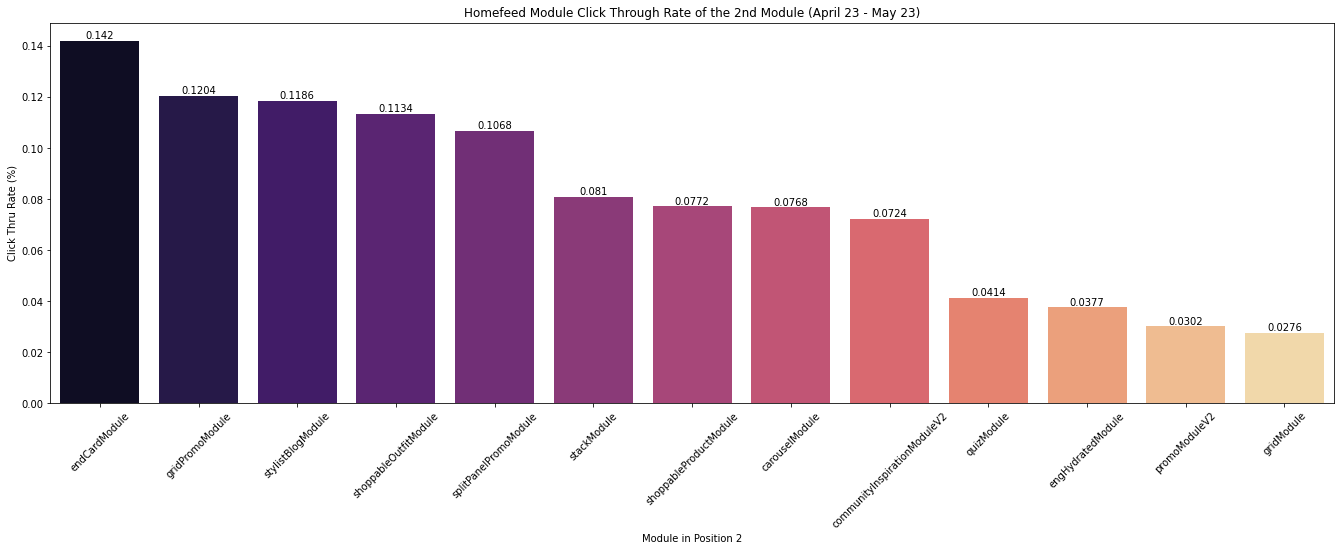

In [44]:
plt.figure(figsize=(23,7))
ax = sns.barplot(x='module', y='ctr', data=mpif_2, palette = 'magma')
ax.bar_label(ax.containers[0])
ax.set(xlabel='Module in Position 2', ylabel='Click Thru Rate (%)')
plt.title("Homefeed Module Click Through Rate of the 2nd Module (April 23 - May 23)")
plt.xticks(rotation = 45)

In [45]:
mpif_3 = mpif[mpif['position_in_feed'] == 3].sort_values(['ctr'], ascending = False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'endCardModule'),
  Text(1, 0, 'gridPromoModule'),
  Text(2, 0, 'shoppableOutfitModule'),
  Text(3, 0, 'stylistBlogModule'),
  Text(4, 0, 'splitPanelPromoModule'),
  Text(5, 0, 'carouselModule'),
  Text(6, 0, 'stackModule'),
  Text(7, 0, 'shoppableProductModule'),
  Text(8, 0, 'communityInspirationModuleV2'),
  Text(9, 0, 'quizModule'),
  Text(10, 0, 'engHydratedModule'),
  Text(11, 0, 'promoModuleV2'),
  Text(12, 0, 'gridModule')])

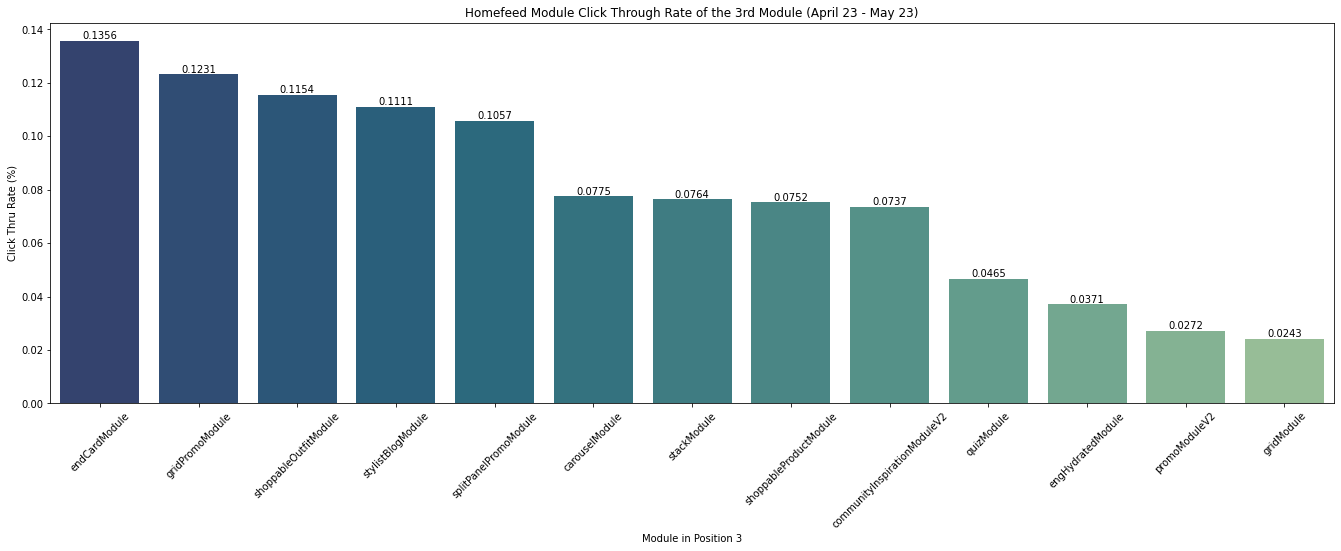

In [46]:
plt.figure(figsize=(23,7))
ax = sns.barplot(x='module', y='ctr', data=mpif_3, palette = 'crest_r')
ax.bar_label(ax.containers[0])
ax.set(xlabel='Module in Position 3', ylabel='Click Thru Rate (%)')
plt.title("Homefeed Module Click Through Rate of the 3rd Module (April 23 - May 23)")
plt.xticks(rotation = 45)

In [239]:
# Best module per position
bmpp = query("""
with cte as (

select
    module,
    cast(json_extract(parent_module_entry[1], '$.feedSequenceNumber') as int) as position_in_feed,
    sum(case when action_type = 'scroll' then 1 else 0 end) as viewed,
    sum(case when action_type = 'click' then 1 else 0 end) as clicked,
    round(sum(case when action_type = 'click' then 1 else 0 end)/cast(sum(case when action_type = 'scroll' then 1 else 0 end) as double),4) as ctr,
    row_number() over (partition by cast(json_extract(parent_module_entry[1], '$.feedSequenceNumber') as int) order by round(sum(case when action_type = 'click' then 1 else 0 end)/cast(sum(case when action_type = 'scroll' then 1 else 0 end) as double),4) desc) as row_num
from apoc.module_interactions
where parent_module_entry is not null
and cast(date_parse(dateint,'%Y%m%d') as date) >= date('2022-03-12') and cast(date_parse(dateint,'%Y%m%d') as date) <= date('2022-04-11')
group by 1,2
order by 2,5 desc

)

select
    position_in_feed,
    module,
    ctr
from cte
where row_num = 1
order by 1
""")

In [240]:
display(bmpp)

,position_in_feed,module,ctr
0,1,communityInspirationModuleV2,0.2390
1,2,communityInspirationModuleV2,0.2150
2,3,communityInspirationModuleV2,0.2156
3,4,communityInspirationModuleV2,0.2074
4,5,communityInspirationModuleV2,0.2159
5,6,communityInspirationModuleV2,0.2146
6,7,communityInspirationModuleV2,0.2142
7,8,communityInspirationModuleV2,0.2152
8,9,communityInspirationModuleV2,0.2160
9,10,communityInspirationModuleV2,0.2732
